# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
The model which you will be coding in this HW very similar to the Speller module from HW4P2.

# Get modules and datasets

In [1]:
!pip install torchsummaryX
!pip install -q cohere tiktoken openai
!pip install -q pytorch-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.6 MB/s eta 0:00:00


In [2]:
# TODO: Import drive if you are using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
path = "/content/drive/MyDrive/hw4p1_handout/handout" # TODO: Add path to handout. For example D:/IDL/hw4/hw4p1_handout/handout
sys.path.append(path)
%cd {path}

/content/drive/MyDrive/IDL/hw4p1_handout/handout


# Imports

In [6]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchsummaryX
from torchnlp.nn import LockedDropout
# Importing necessary modules from hw4
from hw4.tests_hw4 import get_prediction_nll, make_generation_text

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


# Load datasets

In [28]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']


In [29]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

# The dataset does not have <sos> and <eos> because they are just regular articles.
# TODO: Add <sos> and <eos> to every article in the dataset.
for i in range(len(dataset)):
  dataset[i] = np.concatenate(([SOS_TOKEN],dataset[i],[EOS_TOKEN]))
# Before doing do, try printing the dataset to see if they are words or integers.
for i in range(10):
  print(dataset[i])

[33278  1420 13859 ...    79  1417 33279]
[33278  1420 13463 ...    79  1417 33279]
[33278  1420  1419 ...   743  1417 33279]
[33278  1420  5925 33004    64 25399 21405 31205  1420  1417 13276  5925
 33004    64 25399 21405 31205 28489 31353  5925 22968 23428 21405 17840
    79 13276 31205    76 22678    76 22324 25639 17835 22968 14658 24686
 28034 16802  5361    76 31353 30248    64 23428 21986 16457    76 19149
 31352 25990 33004    64 21405 22324 16176 26808 22968 31353 18425 29755
   785    79 13276  5925 22324 31994 33150 31210    76 15310 32084  1424
   460 29691 31352 22324 17835 22968  5361 13689  1424   460 14397    64
 14424  4296 27696    76 15340 15310 32084  1424   664 29691 31352 32984
 21626 28207 27696 21415 15310 32084  1424   664 14424  4296    79 13276
 19211 25821 14658 25399 31205 20850 17189 29736 31543 31435 14842  1626
    76 15238 31353 25399 21405 15741 22324 21532 30323 24807 21372 25871
 33004    64 21405    79  1417  1420  1420 13276 31205  1420  1420  141

In [30]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [31]:
# Loading the test fixtures for generation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test
fixtures_gen = np.load('fixtures/generation.npy')

print("Test Gen Shapes          :", fixtures_gen_test.shape)
print("Validation Gen Shapes          :", fixtures_gen.shape)


Test Gen Shapes          : (128, 31)
Validation Gen Shapes          : (32, 21)


In [32]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs

for i in range(10):
  print(fixtures_pred['inp'][i])
  print(fixtures_pred['out'][i])

[33278 26096 26972 25821 14658 29325 32935 21820 25639 16134 31353 29092
    79  6916    76 21415 14658 24911  1424 29456 29325]
72
[33278 14658 21076 21626 31353  6613  1419 10706 15340 25874 25949 31994
 21626  2299  3952    79  1419    76  1184 31543  1242]
24820
[33278  1419 15219 27351 25131 21415 32352 25871 31353 28863    76 31353
 21201 31994 25821 32883 19278 21626 31353 25806  1424]
21959
[33278  6591 25821  1419    79 12269 22213 16176 18272 21626 14658 17765
 32503 22968  9810 10184 21415 28860 15340 17575 21114]
79
[33278 31353 21111 28343 18250    76 15659  1419 31326 27001 21415 20086
 24118 25821  1419 27297 31543 22534 25537 21111    79]
1419
[33278 31353 32715    76 16786 31399 32846 28744 15039  9224    79 10696
 21415 25177 20037  1419 32846 28262 25871 31353 22122]
25821
[33278 23039 25949 18869 22968 31891 18709 23374    79 12559 31891 18710
  1419 22968 30596 25177 31348 31353   792  1425  1114]
13052
[33278 32747 31136 32978 14658 21076 19825 32899 18395 28456 2

# Custom DataLoader

In [33]:
from torch.utils.data.dataloader import Dataset
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size,sequence_length, shuffle= True, drop_last= False):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.sequence_length = sequence_length

        self.dataset = np.concatenate(dataset, axis=0)
        self.num_batches = len(self.dataset) // (self.batch_size * self.sequence_length)

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        return self.num_batches

    def __iter__(self):
        # TODOs:
        # 1. Shuffle data if shuffle is True
        # 2. Concatenate articles and drop extra words
        # 3. Divide the concetenated dataset into inputs and targets. How do they vary?
        # 4. Reshape the inputs and targets into batches (think about the final shape)
        # 5. Loop though the batches and yield the input and target according to the sequence length

        if self.shuffle:
            # TODO
            np.random.shuffle(dataset)

        batch_idx = 0
        inputs = []
        targets = []
        input_length = self.batch_size * self.sequence_length

        while batch_idx < self.num_batches:
          inputs = self.dataset[batch_idx*input_length:(batch_idx+1)*input_length]
          targets = self.dataset[batch_idx*input_length+1:(batch_idx+1)*input_length+1]
          inputs = torch.tensor(inputs, dtype=torch.long)
          targets = torch.tensor(targets, dtype=torch.long)
          inputs = inputs.reshape(((self.batch_size, self.sequence_length)))
          targets = targets.reshape(((self.batch_size, self.sequence_length)))
          yield inputs, targets
          batch_idx+=1


In [34]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 32,
    shuffle     = True,
    drop_last   = True,
    sequence_length= 3
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

torch.Size([32, 3]) torch.Size([32, 3])
x:  ['<sos>', '=', 'Valkyria']
y:  ['=', 'Valkyria', 'Chronicles']


# LanguageModel

In [35]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2.
# However, using LSTMCells will make this Language model very similar to the decoder in HW4P2 and we recommend you use that for writing resuable code.

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, num_lstm_layers): # TODO: Add more parameters if you want
        super().__init__()

        # For all the layers which you will define, please read the documentation thoroughly before implementation
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers

        self.token_embedding    = torch.nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim) # Define a PyTorch embedding layer

        self.lstm_cells = torch.nn.Sequential()
        for layer in range(self.num_lstm_layers):
            self.lstm_cells.append(torch.nn.LSTMCell(input_size=self.embedding_dim if layer == 0 else self.hidden_size, hidden_size=self.embedding_dim if layer == 2 else self.hidden_size))

        self.token_probability  = torch.nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size) # Define the parameters



        # Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight.
        self.token_embedding.weight   = self.token_probability.weight
        self.drop = torch.nn.Dropout(0.2)
        self.lock = LockedDropout(configs['p_value'])
        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def rnn_step(self, embedding, hidden_states_list):
      """
      This method iterates over our LSTMCell layers defined in self.lstm_cells.
      At each iteration, our LSTMCell layers take in a token embedding at timestep
      t and the hidden state at each layer and computes the next hidden state.

      The method returns the final hidden state output and our final list of hidden states
      """

      # iterate over our LSTMCell layers
      embedding = self.drop(embedding)
      for i in range(len(self.lstm_cells)):
          if i != 0:
            embedding = embedding.unsqueeze(0)
            embedding = self.lock(embedding)
            embedding = embedding.squeeze(0)

          # Forward pass through each LSTMCell
          # Obtain the embedding and hidden_state
          hidden_state, cell_state = self.lstm_cells[i](embedding, hidden_states_list[i])
          # the embedding for the next layer will be the hidden state of the current layer
          hidden_states_list[i] = (hidden_state, cell_state)
          embedding = hidden_state # (batch_size, hidden_size)

      return embedding, hidden_states_list

    def predict(self, x):
        # Refer to Section 1.3.1 to understand this function
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        with torch.inference_mode():
            # Pass the input sequence through the model - perform a forward pass
            model_out, _ = self.forward(x) # model_out.shape = (batch_size, timesteps, vocab_size)

            # and return the probability distribution (scores) for the last timestep
            final_out = model_out[:, -1, :]
            return final_out

    def generate(self, x, timesteps):
        # Refer to section 1.3.2 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # TODO: Pass the input sequence through the model
        # Obtain the probability distribution and hidden_states_list of the last timestep

        token_prob_distribution, hidden_states_list = self.forward(x)
        next_token_prob_distribution = token_prob_distribution[:, -1, :] # (batch_size, vocab_size)
        next_token = torch.argmax(next_token_prob_distribution, dim=1) # (batch_size, ) returns a list of <batch_size> indices where each index in a batch is the token with the highest probability

        generated_sequence  = [next_token]
        current_context = x
        with torch.inference_mode():
            for t in range(timesteps-1): # Loop through the timesteps

                # Pass the next_token and hidden_states_list through the model
                #You will get 2 outputs. What is the shape of the probability distribution?
                #   TODO: Get the most probable token for the next timestep

                next_token_reshaped = next_token.reshape(-1, 1) # reshape token to have matching dims (batch_size, 1)
                current_context = torch.cat((current_context, next_token_reshaped), dim=1) # concatenate along the sequence_len dimension

                token_prob_distribution, hidden_states_list = self.forward(current_context, hidden_states_list)
                next_token_prob_distribution = token_prob_distribution[:, -1, :NUM_WORDS] # (batch_size, vocab_size-2) ; excluding <sos> and <eos>
                next_token = torch.argmax(next_token_prob_distribution, dim=1) # (batch_size, )

                generated_sequence.append(next_token)

            generated_sequence = torch.stack(generated_sequence, dim= 1)

        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        """
        compute the probability of a complete token sequence
        ensure <sos> and <eos> are included
        """
        # x (batch_size, sequence_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        batch_size, timesteps   = x.shape

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps
        # Initializing the hidden states.
        hidden_states_list      = [None]*self.num_lstm_layers if hidden_states_list is None else hidden_states_list

        token_embeddings        = self.token_embedding(x)
        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            # get the embedding of input at the current timestep. you don't need to get the embeddings UPTO the current timesteps since the RNN hidden states will capture that information
            token_embedding_t           = token_embeddings[:, t, :] # (batch_size, 1, embedding_dim)

            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list) # (What should you do with the hidden_states_list?)

            token_prob_dist_t           = self.token_probability(rnn_out) # (batch_size, vocab_size)

            token_prob_distribution.append(token_prob_dist_t) # (timesteps, batch_size, vocab_size)

        token_prob_distribution = torch.stack(token_prob_distribution, dim=1) # Stack along the timesteps dimension (batch_size, timesteps, vocab_size)

        return token_prob_distribution, hidden_states_list

In [36]:
# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Trainer Class

In [37]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler = scheduler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []



        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.reshape(-1,out.size(-1)) # TODO
        targets = target.reshape(-1)# TODO
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0

        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):

            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Mixed precision training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.
            self.optimizer.zero_grad()

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            with torch.cuda.amp.autocast():
              token_prob_distribution, _ = self.model(inputs)
              loss =self.calculate_loss(token_prob_distribution,targets)

            epoch_loss += loss.item()


            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                      % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        prediction_probs     = self.model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs.append(prediction_probs)


        generated_indexes_test   = self.model.generate(fixtures_gen_test, 10).detach().cpu().numpy() # generated predictions for 10 words

        nll                   = get_prediction_nll(prediction_probs, fixtures_pred['out'])

        generated_texts_test  = make_generation_text(fixtures_gen_test, generated_indexes_test, VOCAB)
        self.val_losses.append(nll)

        self.generated_texts_test.append(generated_texts_test)


        # generate predictions for test data
        prediction_probs_test = self.model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs_test.append(prediction_probs_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll


    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'prediction-probs-{}.npy'.format(self.epochs)), self.prediction_probs[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'prediction-probs-test-{}.npy'.format(self.epochs)), self.prediction_probs_test[-1])


        with open(os.path.join('hw4/experiments', self.run_id, 'generated-texts-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_texts_test[-1])

# Experiment setup

In [38]:
# define other hyperparameters here

configs = dict(
    batch_size  = 256,
    num_epochs  = 25, # 10 or 20 epochs should be enough given the model is good
    init_lr     = 1e-3,
    sequence_length = 10,
    embedding_dim = 300,
    hidden_size = 1024,
    num_lstm_layers = 3,
    gamma = 0.95,
    weight_decay=1e-6,
    p_value = 0.3
)

In [40]:
# Define the model
model = LanguageModel(
    vocab_size=len(VOCAB),
    embedding_dim=configs['embedding_dim'],
    hidden_size=configs['hidden_size'],
    num_lstm_layers=configs['num_lstm_layers']
    ).to(DEVICE)

# Define the dataloader
loader = DataLoaderForLanguageModeling(
    dataset=dataset,
    batch_size=configs['batch_size'],
    sequence_length=configs['sequence_length'],
    shuffle= True,
    drop_last= False)

criterion   = torch.nn.CrossEntropyLoss()

optimizer   = torch.optim.Adam(model.parameters(), weight_decay=configs['weight_decay'], lr=configs['init_lr'])# Define the optimizer. Adam/AdamW usually works good for this HW

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=configs['gamma'])

print(model)
torchsummaryX.summary(model, x = inputs.to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 300)
  (lstm_cells): Sequential(
    (0): LSTMCell(300, 1024)
    (1): LSTMCell(1024, 1024)
    (2): LSTMCell(1024, 300)
  )
  (token_probability): Linear(in_features=300, out_features=33280, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (lock): LockedDropout(p=0.3)
)
                          Kernel Shape   Output Shape     Params  Mult-Adds
Layer                                                                      
0_token_embedding         [300, 33280]   [32, 3, 300]     9.984M     9.984M
1_drop                               -      [32, 300]          -          -
2_lstm_cells.LSTMCell_0              -     [32, 1024]  5.431296M  5.423104M
3_lock                               -  [1, 32, 1024]          -          -
4_lstm_cells.LSTMCell_1              -     [32, 1024]    8.3968M  8.388608M
5_lock                               -  [1, 32, 1024]          -          -
6_lstm_cells.LSTMCell_2              -      [32, 300]    1.5912

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embedding,"[300, 33280]","[32, 3, 300]",9984000.0,9984000.0
1_drop,-,"[32, 300]",NaN,NaN
2_lstm_cells.LSTMCell_0,-,"[32, 1024]",5431296.0,5423104.0
3_lock,-,"[1, 32, 1024]",NaN,NaN
4_lstm_cells.LSTMCell_1,-,"[32, 1024]",8396800.0,8388608.0
5_lock,-,"[1, 32, 1024]",NaN,NaN
6_lstm_cells.LSTMCell_2,-,"[32, 300]",1591200.0,1588800.0
7_token_probability,"[300, 33280]","[32, 33280]",10017280.0,9984000.0
8_drop,-,"[32, 300]",NaN,NaN


In [49]:
!pwd

'/content/drive/MyDrive/IDL/hw4p1_handout/handout'

In [41]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, prediction prbabilities, and generated texts to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,

    max_epochs  = configs['num_epochs'],
    run_id      = run_id
)

Saving models, prediction prbabilities, and generated texts to ./hw4/experiments/1701090373


In [42]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

%%time
best_nll = 1e30
for epoch in range(configs['num_epochs']):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, prediction probabilities and generated texts for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [1/25] 	Loss: 7.2997 	Lr: 0.001000
[VAL] 	Epoch [1/25] 	Loss: 6.2749
Saving model, prediction probabilities and generated texts for epoch 1 with NLL: 6.2749023


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/25] 	Loss: 6.4716 	Lr: 0.001000
[VAL] 	Epoch [2/25] 	Loss: 5.5879
Saving model, prediction probabilities and generated texts for epoch 2 with NLL: 5.5879493


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/25] 	Loss: 5.9557 	Lr: 0.001000
[VAL] 	Epoch [3/25] 	Loss: 5.1515
Saving model, prediction probabilities and generated texts for epoch 3 with NLL: 5.151531


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/25] 	Loss: 5.6391 	Lr: 0.001000
[VAL] 	Epoch [4/25] 	Loss: 4.9019
Saving model, prediction probabilities and generated texts for epoch 4 with NLL: 4.9019084


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/25] 	Loss: 5.4189 	Lr: 0.001000
[VAL] 	Epoch [5/25] 	Loss: 4.7631
Saving model, prediction probabilities and generated texts for epoch 5 with NLL: 4.763068


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/25] 	Loss: 5.2474 	Lr: 0.001000
[VAL] 	Epoch [6/25] 	Loss: 4.6488
Saving model, prediction probabilities and generated texts for epoch 6 with NLL: 4.648778


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/25] 	Loss: 5.1091 	Lr: 0.001000
[VAL] 	Epoch [7/25] 	Loss: 4.5683
Saving model, prediction probabilities and generated texts for epoch 7 with NLL: 4.56831


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/25] 	Loss: 4.9927 	Lr: 0.001000
[VAL] 	Epoch [8/25] 	Loss: 4.4989
Saving model, prediction probabilities and generated texts for epoch 8 with NLL: 4.4988794


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/25] 	Loss: 4.8939 	Lr: 0.001000
[VAL] 	Epoch [9/25] 	Loss: 4.5272


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/25] 	Loss: 4.8064 	Lr: 0.001000
[VAL] 	Epoch [10/25] 	Loss: 4.5218


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [11/25] 	Loss: 4.7288 	Lr: 0.001000
[VAL] 	Epoch [11/25] 	Loss: 4.5387


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [12/25] 	Loss: 4.6590 	Lr: 0.001000
[VAL] 	Epoch [12/25] 	Loss: 4.4797
Saving model, prediction probabilities and generated texts for epoch 12 with NLL: 4.4797153


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [13/25] 	Loss: 4.5954 	Lr: 0.001000
[VAL] 	Epoch [13/25] 	Loss: 4.4416
Saving model, prediction probabilities and generated texts for epoch 13 with NLL: 4.441555


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [14/25] 	Loss: 4.5383 	Lr: 0.001000
[VAL] 	Epoch [14/25] 	Loss: 4.5826


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [15/25] 	Loss: 4.4862 	Lr: 0.001000
[VAL] 	Epoch [15/25] 	Loss: 4.5259


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [16/25] 	Loss: 4.4366 	Lr: 0.001000
[VAL] 	Epoch [16/25] 	Loss: 4.4931


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [17/25] 	Loss: 4.3930 	Lr: 0.001000
[VAL] 	Epoch [17/25] 	Loss: 4.4929


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [18/25] 	Loss: 4.3530 	Lr: 0.001000
[VAL] 	Epoch [18/25] 	Loss: 4.5711


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [19/25] 	Loss: 4.3139 	Lr: 0.001000
[VAL] 	Epoch [19/25] 	Loss: 4.5442


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [20/25] 	Loss: 4.2779 	Lr: 0.001000
[VAL] 	Epoch [20/25] 	Loss: 4.5392


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [21/25] 	Loss: 4.2442 	Lr: 0.001000
[VAL] 	Epoch [21/25] 	Loss: 4.5002


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [22/25] 	Loss: 4.2121 	Lr: 0.001000
[VAL] 	Epoch [22/25] 	Loss: 4.5428


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [23/25] 	Loss: 4.1824 	Lr: 0.001000
[VAL] 	Epoch [23/25] 	Loss: 4.6005


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [24/25] 	Loss: 4.1542 	Lr: 0.001000
[VAL] 	Epoch [24/25] 	Loss: 4.5876


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [25/25] 	Loss: 4.1268 	Lr: 0.001000
[VAL] 	Epoch [25/25] 	Loss: 4.6195
CPU times: user 20min 2s, sys: 17.2 s, total: 20min 19s
Wall time: 21min


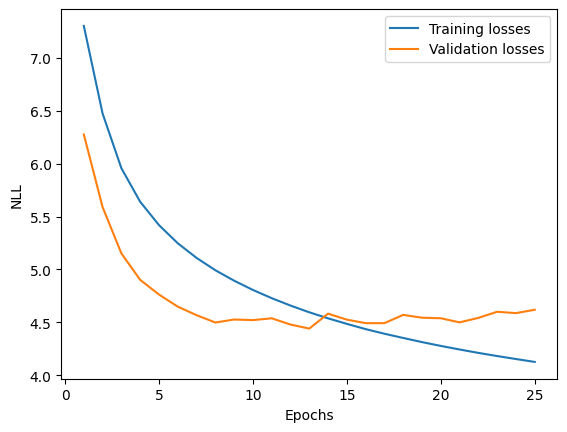

In [43]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# Evaluating generations

In [44]:
!pip install openai==0.28

In [45]:
# Now that you have trained your model and got satisfactory validation NLL on the single token prediction task,
# you can evaluate the generations you created too. We will use the perplexity metric to evaluate generations
# using a large language model available through the OpenAI API. Read the handout for instructions on how to sign
# up for the API and obtain and API key. Once you add credits to your account, run this cell to get the perplexity.
# You will submit this perplexity value for grading the generation component of this homework.
# A perplexity of under <tbd> will give you full credit on the generation part.

# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT submission_run_id, submission_epoch, AND api_key
# PLEASE BE HONEST IN REPORTING THE PERPLEXITY VALUE!
# WE WILL RANDOMLY CHECK SOME SUBMISSIONS USING THE SAME CODE AS THIS AND A BIG DIFFERENCE IN PERPLEXITY WILL RESULT IN AN AIV.

import openai

# Fill the run id and epoch number to be used for submission.
# You will use the same run id and epoch number to generate the handin.
submission_run_id = run_id # TODO
submission_epoch = '13' # TODO

n_tests = 128

with open(os.path.join('hw4/experiments', submission_run_id, 'generated-texts-{}-test.txt'.format(submission_epoch)), 'r', encoding='utf-8') as f:
    generated = list(f)

assert len(generated) == n_tests
for item in generated:
    assert type(item) is str

parsed_generated = []

for text in generated:
    start_index = text.index("<sos>")
    temp = text[start_index+6:]
    generation_start_index = temp.index("| ")
    parsed_text = temp[:generation_start_index] + temp[generation_start_index+2:]
    parsed_text = parsed_text.replace("<eol>", "\n")
    parsed_generated.append(parsed_text)

def perplexity(text, modelname):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=modelname,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    ll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-ll)
    return ppl

# Add you API key here to get perplexity. However, delete the key from the notebook before creating the handin.
# REMEMBER: ALWAYS KEEP YOUR API KEYS AND SECRETS SECURE.
openai.api_key = 'openai-api-key' # TODO
modelname = 'text-embedding-ada-002'

perps = [perplexity(text, modelname) for text in tqdm(parsed_generated)]
avg_perp = np.mean(perps)

# Report this number when running the makefile to create the handin
print("Your mean perplexity for generated sequences: {}".format(avg_perp))

  0%|          | 0/128 [00:00<?, ?it/s]

Your mean perplexity for generated sequences: 1374.6164433397932


In [47]:
avg_perp

1374.6164433397932

In [53]:
run_id

'1701090373'

# Create handin
Navigate to the handout directory to run the below cell. This command will create the handin with all the required files (including attention.py). So make sure you have the entire handout directory wherever you are running this notebook (local machine, Colab, AWS, etc.). This command requires that this completed notebook be in the hw4 folder inside the handout directory.

In [54]:
# TODO: Generate the handin to submit to autolab
# For example make runid=1234 epoch=4 genppl=123.4
!make runid=1701090373 epoch=13 ppl=1374.6164433397932

echo 1374.6164433397932 > generation_ppl.txt
cp hw4/experiments/1701090373/prediction-probs-test-13.npy prediction_probs.npy
cp hw4/experiments/1701090373/generated-texts-13-test.txt generated_texts.txt
cp hw4/hw4p1.ipynb training.ipynb
cp hw4/attention.py attention.py
tar -cvzf handin.tar training.ipynb prediction_probs.npy generated_texts.txt generation_ppl.txt attention.py
training.ipynb
prediction_probs.npy
generated_texts.txt
generation_ppl.txt
attention.py
rm -f generated_texts.txt prediction_probs.npy training.ipynb generation_ppl.txt attention.py


'1701090373'